In [1]:
# Needed to reload modified modules
%load_ext autoreload
%autoreload 2

In [2]:
# Evaluate the ML model
import numpy as np
import os
import matplotlib.pyplot as plt
from utils import unnormalize_params
from utils import fast_tensor_load
from models import EncoderMulti
from sklearn.metrics import mean_squared_error, mean_absolute_error

# data_dir = './tomo_data/datasets_encoder_TF_03-03-23'
# data_dir = './tomo_data/datasets_encoder_TF_24-03-23'
data_dir = './tomo_data/datasets_encoder_TF_08-11-23'


dataset_percent = 0.5
normalization = 'minmax'
img_normalize = 'off'
num_Turns_Case = 1

var_names = ['phEr', 'enEr', 'bl',
             'inten', 'Vrf', 'mu', 'VrfSPS']
# timestamp = get_best_model_timestamp('./trials', model='enc')
# timestamp = 'best_encoder_TF'
timestamp = 'best_encoder_TF_no_intensity'

2024-02-06 15:21:34.050703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-06 15:21:43.772515: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-06 15:21:46.289634: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/anaconda3/lib:/home/kiliakis/install/lib
2024-02-06 15:21:46

In [3]:
# Initialize parameters
import time

# Initialize train/ test / validation paths
ML_dir = os.path.join(data_dir, 'ML_data')
assert os.path.exists(ML_dir)

assert normalization == 'minmax'
assert img_normalize == 'off'
TESTING_PATH = os.path.join(ML_dir, 'testing-??.npz')

# First the training data
start_t = time.time()
x_test, y_test = fast_tensor_load(TESTING_PATH, dataset_percent)
print('Number of Testing files: ', len(y_test))
total_time = time.time() - start_t
print(f'Elapsed time: {total_time:.3f}, Per file: {total_time/len(y_test):.3f}')


Loading ./tomo_data/datasets_encoder_TF_08-11-23/ML_data/testing-00.npz


2024-02-06 15:23:14.423662: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/anaconda3/lib:/home/kiliakis/install/lib
2024-02-06 15:23:14.437426: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-02-06 15:23:14.437472: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sy153): /proc/driver/nvidia/version does not exist
2024-02-06 15:23:14.636054: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appr

Number of Testing files:  697
Elapsed time: 3.165, Per file: 0.005


In [4]:
# Model to load

print(timestamp)

# Initialize directories
trial_dir = os.path.join('./trials/', timestamp)
weights_dir = os.path.join(trial_dir, 'weights')
plots_dir = os.path.join(trial_dir, 'plots')
assert os.path.exists(weights_dir)
os.makedirs(plots_dir, exist_ok=True)

encoder = EncoderMulti()
encoder.load(weights_dir)



best_encoder_TF_no_intensity


In [5]:
encoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 128, 128, 1)]     0         
                                                                 
 Crop (Cropping2D)           (None, 128, 128, 1)       0         
                                                                 
 phEr_CNN_1 (Conv2D)         (None, 64, 64, 8)         392       
                                                                 
 phEr_CNN_2 (Conv2D)         (None, 32, 32, 16)        6272      
                                                                 
 phEr_CNN_3 (Conv2D)         (None, 16, 16, 32)        25088     
                                                                 
 phEr_Flatten (Flatten)      (None, 8192)              0         
                                                                 
 phEr_Dense_1 (Dense)        (None, 1024)              8389

In [6]:
import visualkeras

for model in encoder.model:
    visualkeras.layered_view(model.model, to_file=os.path.join(plots_dir, f'encoder-{model.output_name}-visual.png'), 
                         legend=True, index_ignore=[1], max_z=100, max_xy=400, draw_volume=True).show()

ModuleNotFoundError: No module named 'visualkeras'

In [6]:
test_pred = encoder.predict(x_test)
print(test_pred.shape)
test_mse = mean_squared_error(y_test, test_pred, multioutput='raw_values')


(697, 7)


In [7]:
# test_losses = {}
# for var_name in var_names:
#     model = encoder.model[var_names.index(var_name)]
#     # if var_name == 'inten':
#     #     continue
#     idx = var_names.index(var_name)
#     # print(f'------ Evaluating {var_name} ------')
#     test_loss = model.evaluate(x_test, tf.gather(y_test, idx, axis=1))
#     # print(test_loss)
#     if isinstance(test_loss, float):
#         test_losses[var_name] = test_loss
#     else:
#         test_losses[var_name] = test_loss[0]

# for name, mse in test_losses.items():
#     print(f'{name}:\t{mse:.3e}')

# print(f'\nMean loss: {np.mean([v for v in test_losses.values()]):.3e}')


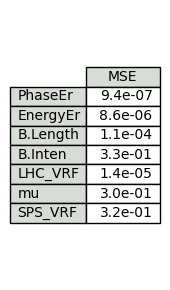

In [8]:
# Generate table and save
plt.figure(figsize=(1.8, 3))
plt.axis('off')
rowLabels = ['PhaseEr', 'EnergyEr', 'B.Length', 'B.Inten', 'LHC_VRF', 'mu', 'SPS_VRF']
rowColours = ['xkcd:light grey'] * len(rowLabels)
colColours = ['xkcd:light grey']
cellColours = [['white'] for i in range(len(rowLabels))]
cellText = [[f'{l:.1e}'] for l in test_mse]

plt.table(cellText=cellText, rowLabels=rowLabels, colLabels=['MSE'],
          loc='center', rowColours=rowColours, colColours=colColours,
          cellColours=cellColours)
plt.tight_layout()
plt.savefig(f'{plots_dir}/mse-table.png',
            dpi=400, bbox_inches='tight', transparent=True)


(697, 7)
phEr:	7.444e-02	1.832e-01
enEr:	4.576e-01	1.193e+00
bl:	5.089e-12	1.186e-11
inten:	1.428e+11	2.748e+11
Vrf:	1.782e-02	4.548e-02
mu:	1.914e+00	3.605e+00
VrfSPS:	3.410e+00	6.712e+00
(7,)


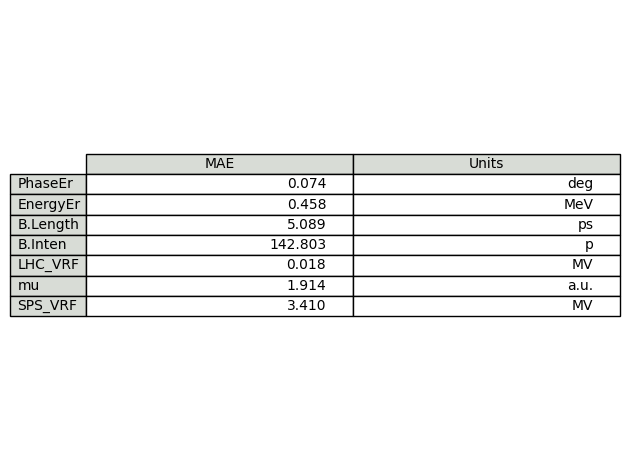

In [10]:

y_test_unnorm = unnormalize_params(
    y_test[:, 0], y_test[:, 1], y_test[:, 2],
    y_test[:, 3], y_test[:, 4], y_test[:, 5],
    y_test[:, 6], normalization=normalization)

y_pred_unnorm = unnormalize_params(
    test_pred[:, 0], test_pred[:, 1], test_pred[:, 2],
    test_pred[:, 3], test_pred[:, 4], test_pred[:, 5],
    test_pred[:, 6], normalization=normalization)

y_test_unnorm = np.array(y_test_unnorm).T
y_pred_unnorm = np.array(y_pred_unnorm).T

# I want to calcualte the mean absolute error, and the 95th percentile of the absolute error, for each parameter
diffs = np.abs(np.array(y_pred_unnorm) - np.array(y_test_unnorm))
print(diffs.shape)

for name, mae, perc95 in zip(var_names, np.mean(diffs, axis=0), np.percentile(diffs, 95, axis=0)):
    print(f'{name}:\t{mae:.3e}\t{perc95:.3e}')

test_mse_unnorm = mean_absolute_error(y_test_unnorm, y_pred_unnorm, multioutput='raw_values')
test_mse_unnorm = np.array([mse * mult for mse, mult in zip(test_mse_unnorm, [1, 1, 1e12, 1e-9, 1, 1, 1])])
print(test_mse_unnorm.shape)


# plt.figure(figsize=(1.8, 3))
plt.axis('off')
rowLabels = ['PhaseEr', 'EnergyEr', 'B.Length', 'B.Inten', 'LHC_VRF', 'mu', 'SPS_VRF']
rowColours = ['xkcd:light grey'] * len(rowLabels)
colColours = ['xkcd:light grey', 'xkcd:light grey']
cellColours = [['white', 'white'] for i in range(len(rowLabels))]
cellText = [[f'{l:.3f}', unit] for l, unit in zip(test_mse_unnorm, ['deg', 'MeV', 'ps', 'p', 'MV', 'a.u.', 'MV'])]

plt.table(cellText=cellText, rowLabels=rowLabels, colLabels=['MAE', 'Units'],
          loc='center', rowColours=rowColours, colColours=colColours,
          cellColours=cellColours)
plt.tight_layout()
plt.savefig(f'{plots_dir}/mse-table-unnorm.png',
            dpi=400, bbox_inches='tight', transparent=True)


IndexError: index 51 is out of bounds for axis 0 with size 51

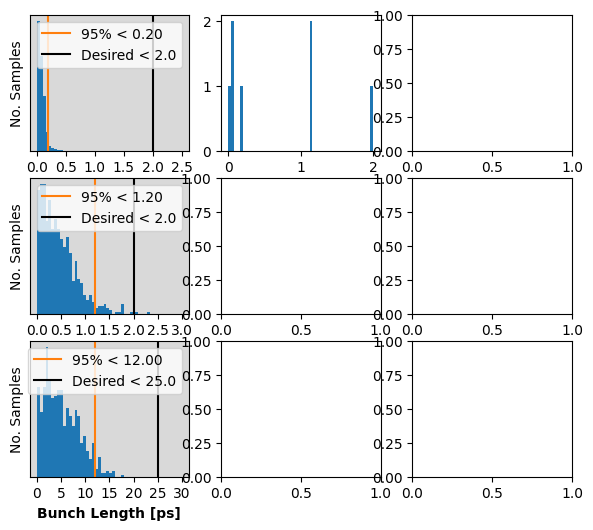

In [8]:
import bisect

# Encoder, graphical evaluation

evaluation_config = {
    0: {'xlabel': 'Phase Error [deg]',
        'range': (0, 2.5),
        'xticks': np.arange(0, 2.6, 0.5),
        'desired': 2,
        'multiplier': 1},
    1: {'xlabel': 'Energy Error [MeV]',
        'range': (0, 3.),
        'xticks': np.arange(0, 3.1, 0.5),
        'desired': 2,
        'multiplier': 1},
    2: {'xlabel': 'Bunch Length [ps]',
        'range': (0, 30),
        'xticks': np.arange(0, 30.5, 5),
        'desired': 25,
        'multiplier': 1e12},
    3: {'xlabel': 'Bunch Intensity [1e9]',
        'range': (0, 2),
        'xticks': np.arange(0, 2.1, 0.5),
        'desired': 1.5,
        'multiplier': 1e-9},
    4: {'xlabel': 'V_rf [MV]',
        'range': (0, 0.15),
        'xticks': np.arange(0, 0.16, 0.05),
        'desired': 0.1,
        'multiplier': 1},
    5: {'xlabel': 'mu [a.u.]',
        'range': (0, 0.4),
        'xticks': np.arange(0, 0.41, 0.1),
        'desired': 0.2,
        'multiplier': 1},
    6: {'xlabel': 'V_rf SPS [MV]',
        'range': (0, 0.25),
        'xticks': np.arange(0, 0.26, 0.05),
        'desired': 0.1,
        'multiplier': 1},
}

fig, axes = plt.subplots(ncols=3, nrows=3, sharex=False,
                         sharey=False, figsize=(7, 6))
axes = np.ravel(axes, order='F')

for idx, ax in enumerate(axes):
    if idx == 7:
        break
    plt.sca(ax)
    config = evaluation_config[idx]
    hist, bins, _ = plt.hist(
        diffs[:, idx]*config['multiplier'], bins=50, range=config['range'])
    cumsum = np.cumsum(hist) / diffs.shape[0]
    b = bisect.bisect(cumsum, 0.95)
    plt.axvline(x=bins[b+1], color='tab:orange',
                label=f'95% < {bins[b+1]:.2f}')
    plt.xticks(config['xticks'])
    plt.yticks([], [])
    plt.xlabel(config['xlabel'], fontweight='heavy')
    if idx < 3:
        plt.ylabel('No. Samples')
    plt.axvline(x=config['desired'], color='black',
                label=f'Desired < {config["desired"]:.1f}')
    plt.legend(loc='upper right')
    plt.gca().set_facecolor('0.85')

# delete last
fig.delaxes(axes[-1])
fig.delaxes(axes[-2])

plt.tight_layout()
plt.savefig(f'{plots_dir}/enc-abs-error.png', transparent=True,
            dpi=400, bbox_inches='tight')


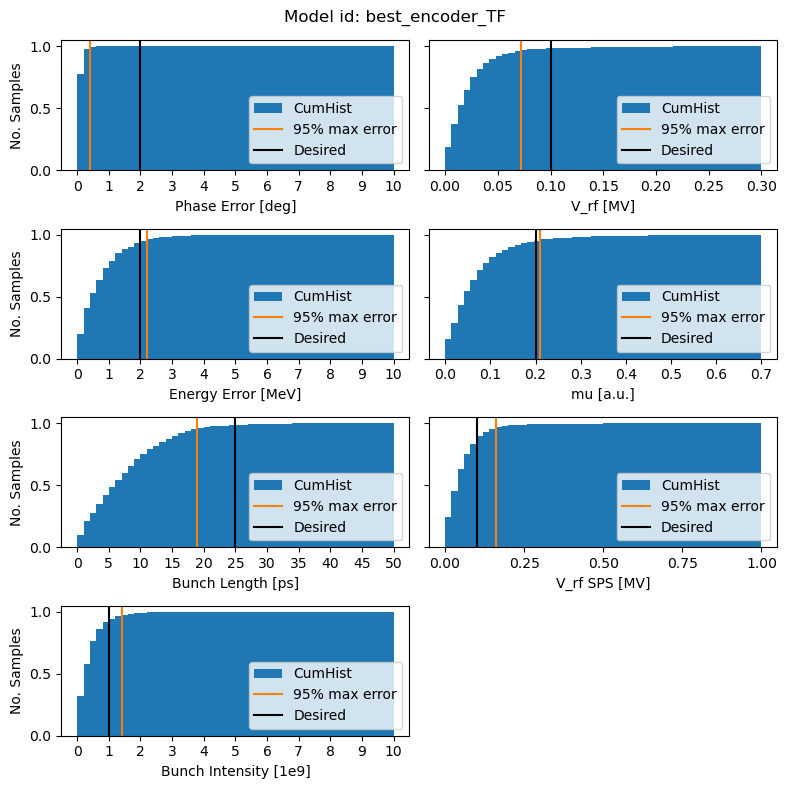

In [49]:
import bisect

fig, axes = plt.subplots(ncols=2, nrows=4, sharex=False,
                         sharey=True, figsize=(8, 8))
fig.suptitle(f'Model id: {timestamp}')

plt.sca(axes[0][0])
n, bins, patches = plt.hist(diffs[:, 0], bins=50, range=(0, 10),
                            cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xticks(np.arange(0, 10.5))
plt.xlabel('Phase Error [deg]')
plt.ylabel('No. Samples')
plt.axvline(x=2, color='black', label='Desired')
plt.legend(loc='lower right')

plt.sca(axes[1][0])
n, bins, patches = plt.hist(diffs[:, 1], bins=50, range=(0, 10),
                            cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xticks(np.arange(0, 10.5))
plt.xlabel('Energy Error [MeV]')
plt.ylabel('No. Samples')
plt.axvline(x=2, color='black', label='Desired')
plt.legend(loc='lower right')

plt.sca(axes[2][0])
n, bins, patches = plt.hist(
    diffs[:, 2]*1e12, bins=50, range=(0, 50),
    cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xticks(np.arange(0, 50.5, 5))
plt.xlabel('Bunch Length [ps]')
plt.ylabel('No. Samples')
plt.axvline(x=25, color='black', label='Desired')
plt.legend(loc='lower right')


plt.sca(axes[3][0])
n, bins, patches = plt.hist(
    diffs[:, 3]*1e-9, bins=50, range=(0, 10),
    cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xticks(np.arange(0, 10.5, 1))
plt.xlabel('Bunch Intensity [1e9]')
plt.ylabel('No. Samples')
plt.axvline(x=1, color='black', label='Desired')
plt.legend(loc='lower right')

plt.sca(axes[0][1])
n, bins, patches = plt.hist(diffs[:, 4], bins=50, range=(0, 0.3),
                            cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xlabel('V_rf [MV]')
plt.axvline(x=0.1, color='black', label='Desired')
plt.legend(loc='lower right')

plt.sca(axes[1][1])
n, bins, patches = plt.hist(diffs[:, 5], bins=50, range=(0, 0.7),
                            cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xticks(np.arange(0, 0.71, 0.1))
plt.xlabel('mu [a.u.]')
plt.axvline(x=0.2, color='black', label='Desired')
plt.legend(loc='lower right')

plt.sca(axes[2][1])
n, bins, patches = plt.hist(diffs[:, 6], bins=50, range=(0, 1),
                            cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xticks(np.arange(0, 1.1, 0.25))
plt.xlabel('V_rf SPS [MV]')
plt.axvline(x=0.1, color='black', label='Desired')
plt.legend(loc='lower right')

fig.delaxes(axes[3][1])

plt.tight_layout()
plt.savefig(f'plots/enc-cumulative-hist-{timestamp}.jpg', dpi=400)


In [ ]:
# Also generate MSE histogram
# print(valid_pred.shape)
# square_errors = ((y_test - test_pred) * (y_test - test_pred))

# fig, axes = plt.subplots(ncols=1, nrows=len(var_names), sharex=False,
# sharey=True, figsize=(8, 16))
# for i, name in enumerate(var_names):
#     hist,edges = np.histogram(square_errors[:, i], bins=10, density=False)
#     hist = hist / len(square_errors[:, i])
#     print(name, hist)
#     ax = axes[i]
#     plt.sca(ax)
#     plt.bar(np.arange(len(hist)), hist, width=0.8)
#     plt.title(name)
#     edges = [f'{e:.4f}' for e in edges]
#     plt.xticks(np.arange(len(hist)), edges[1:])
#     plt.xlabel('Error')
#     plt.ylabel('Density')
#     plt.tight_layout()
